In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from dataclasses import dataclass
from math import erf, sqrt

def normal_cdf(x):
    # Φ(x) using erf (no SciPy needed)
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

@dataclass
class ValuationRegime:
    start: int      # inclusive (1-indexed time)
    end: int        # inclusive
    mu: float       # mean valuation in this regime
    sigma: float    # std dev (kept constant across regimes for simplicity)


# --- define your regimes/env exactly as you already do ---
T = 10000
#B = 30000
n_t = 100
B = int(0.3 * n_t * T)
cost = 5.0
k = 40
p_grid = np.round(np.linspace(cost + 0.5, 20.0, k), 2)
conversion_probability = lambda p: 1-p/20
# Abrupt regime changes (means jump around)
L = T // 4
sigma = 2.0
regimes = [
    ValuationRegime(1,       L,     mu=10.0, sigma=sigma),
    ValuationRegime(L+1,   2*L,     mu=7.5,  sigma=sigma),
    ValuationRegime(2*L+1, 3*L,     mu=12.0, sigma=sigma),
    ValuationRegime(3*L+1,   T,     mu=8.5,  sigma=sigma),
]

In [3]:
import numpy as np
from dataclasses import dataclass
from math import erf, sqrt

class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

def normal_cdf(x):
    # Φ(x) using erf (no SciPy needed)
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

@dataclass
class ValuationRegime:
    start: int      # inclusive (1-indexed time)
    end: int        # inclusive
    mu: float       # mean valuation in this regime
    sigma: float    # std dev (kept constant across regimes for simplicity)

class NonStationaryValuationEnv:
    """
    Non-stationary single-product pricing environment.
    Each regime defines V_t ~ Normal(mu, sigma).
    Conversion probability at round t: q_t(p) = P(V_t >= p) = 1 - Φ((p - mu)/sigma).
    """
    def __init__(self, regimes, cost):
        self.regimes = regimes  # list[ValuationRegime]
        self.cost = float(cost)
        self.rng = np.random.default_rng(123)

    def _regime_at(self, t):
        for reg in self.regimes:
            if reg.start <= t <= reg.end:
                return reg
        return self.regimes[-1]

    def conversion_probability(self, p, t):
        reg = self._regime_at(t)
        z = (p - reg.mu) / reg.sigma
        q = 1.0 - normal_cdf(z)
        return float(np.clip(q, 0.0, 1.0))

    def round(self, t, p_t, n_t=1):
        """
        Simulate one round at time t with posted price p_t to n_t customers.
        Returns:
          d_t : realized demand (units sold)
          r_t : realized revenue ( (p_t - cost) * d_t )
          q_t : conversion probability used this round (for logging/debug)
        """
        q_t = self.conversion_probability(p_t, t)
        d_t = self.rng.binomial(n_t, q_t)
        r_t = (p_t - self.cost) * d_t
        return int(d_t), float(r_t), float(q_t)


In [4]:
def make_stat_env():
    """Return a fresh stationary environment each call."""
    return PricingEnvironment(conversion_probability, cost)

def make_nonstat_env():
    """Return a fresh non-stationary environment each call.
    Re-seeds its RNG so different calls are not identical."""
    env = NonStationaryValuationEnv(regimes, cost=cost)
    env.rng = np.random.default_rng()  # override fixed 123 to vary across trials
    return env


In [5]:
import numpy as np
from collections import deque

class _SoftmaxUCBArmLearner:
    """Stationary-friendly learner: optimistic softmax (OMD + UCB bonus)."""
    def __init__(self, K, rng, beta_ucb=0.9, alpha_ix=0.06, alpha_min=0.0):
        self.K = K
        self.rng = rng
        self.beta_ucb = float(beta_ucb)
        self.alpha0 = float(alpha_ix)
        self.alpha_min = float(alpha_min)
        self.alpha_ix = float(alpha_ix)
        self.w = np.ones(K, dtype=float)      # OMD weights (kept for symmetry; selection uses probs)
        self.N = np.zeros(K, dtype=float)     # (fractional) pulls for UCB bonus
        self.mu = np.zeros(K, dtype=float)    # mean of scaled gains in [-1,1]
        self.t_eff = 0

    def _eta_t(self):
        self.t_eff = max(1, self.t_eff)
        return np.sqrt(2*np.log(self.K) / (self.K * self.t_eff))

    def _probs(self):
        # optimistic score = mean + bonus
        tplays = max(1.0, float(np.sum(self.N)))
        with np.errstate(divide='ignore', invalid='ignore'):
            bonus = self.beta_ucb * np.sqrt(np.log(tplays) / np.maximum(1e-9, self.N))
        bonus[self.N <= 1e-12] = self.beta_ucb * np.sqrt(np.log(max(2.0, tplays)))
        s = self.mu + bonus
        eta = self._eta_t()
        tilt = np.exp(eta * s)
        p = tilt / np.sum(tilt)
        return p

    def select(self):
        p = self._probs()
        idx = int(self.rng.choice(self.K, p=p))
        return idx, float(p[idx]), p

    def update(self, arm_idx, arm_prob_overall, g_scaled):
        # IX estimator with overall selection prob (meta * base)
        # g_scaled is g / G_clip ∈ [-1,1]
        self.t_eff += 1
        self.alpha_ix = max(self.alpha_min, self.alpha0 / np.sqrt(self.t_eff))
        denom = max(self.alpha_ix + arm_prob_overall, 1e-12)
        # OMD-style weight bump (we keep it simple; main effect is via mu/N used in optimism)
        eta = self._eta_t()
        self.w[arm_idx] *= np.exp(eta * (g_scaled / denom))
        # UCB stats
        self.N[arm_idx] += 1.0
        self.mu[arm_idx] += (g_scaled - self.mu[arm_idx]) / self.N[arm_idx]


class _Exp3IXArmLearner:
    """Adversarial-friendly learner: EXP3-IX on arms."""
    def __init__(self, K, rng, alpha_ix=0.06, alpha_min=0.0):
        self.K = K
        self.rng = rng
        self.alpha0 = float(alpha_ix)
        self.alpha_min = float(alpha_min)
        self.alpha_ix = float(alpha_ix)
        self.w = np.ones(K, dtype=float)
        self.t_eff = 0

    def _eta_t(self):
        self.t_eff = max(1, self.t_eff)
        return np.sqrt(2*np.log(self.K) / (self.K * self.t_eff))

    def _probs(self):
        w_norm = self.w / np.sum(self.w)
        return w_norm

    def select(self):
        p = self._probs()
        idx = int(self.rng.choice(self.K, p=p))
        return idx, float(p[idx]), p

    def update(self, arm_idx, arm_prob_overall, g_scaled):
        self.t_eff += 1
        self.alpha_ix = max(self.alpha_min, self.alpha0 / np.sqrt(self.t_eff))
        denom = max(self.alpha_ix + arm_prob_overall, 1e-12)
        eta = self._eta_t()
        self.w[arm_idx] *= np.exp(eta * (g_scaled / denom))


import numpy as np

class BoBWMetaPrimalDualAgent:
    """
    Best-of-both-worlds meta-agent for pricing with an inventory constraint.

    • Two base learners over prices:
        - _SoftmaxUCBArmLearner (stochastic-friendly, optimism)
        - _Exp3IXArmLearner      (adversarial-friendly, EXP3-IX)
      A meta EXP3-IX picks between them each round.

    • Inventory controller:
        Receding-horizon target + PID on *deficit* with adaptive boost and anti-windup.
        Definitions (per round t):
          target_t     = max feasible expected sales per round to finish on time
          deficit_t    = target_t - d_t                 (>0 means behind this round)
          deficit_cum  = (t * B / T) - sold_so_far      (>0 means behind overall)
          deficit_der  = deficit_t - deficit_{t-1}      (change in deficit)
        Control:
          delta_lambda = boost * [ -(Kp*deficit_t + Ki*deficit_cum + Kd*deficit_der) ]
          • Behind  → decrease λ (encourage lower prices → more sales)
          • Ahead   → increase λ
        Anti-windup removes the integral term contribution when λ is saturated.
    """

    def __init__(self, prices, B, T, cost, n_t=1,
                 # meta (experts) IX:
                 meta_alpha_ix=0.06, meta_alpha_min=0.0,
                 # base learners:
                 base_alpha_ix=0.06, base_alpha_min=0.0, base_beta_ucb=0.9,
                 # legacy dual args (kept for compatibility; not used directly):
                 eta_lambda=0.01, lam0=0.0,
                 # PID controller knobs (stronger for non-stationary):
                 use_dynamic_target=True,
                 eta_lambda_p=0.06,   # Kp on per-round deficit
                 eta_lambda_i=0.05,   # Ki on cumulative deficit
                 eta_lambda_d=0.30,   # Kd on deficit change
                 # adaptive boost & anti-windup:
                 boost_max=0.5,       # scales delta_lambda by (1 + boost_max * tanh(deficit_cum / (n_t*boost_den)))
                 boost_den=10.0,
                 lambda_soft_cap=None,  # if None, only lower bound at 0
                 seed=42):
        self.prices = np.array(prices, dtype=float)
        self.K = len(self.prices)
        self.B = float(B)
        self.T = int(T)
        self.cost = float(cost)
        self.n_t = int(n_t)

        self.rng = np.random.default_rng(seed)

        # ---- base learners (must exist in your file) ----
        self.stoch = _SoftmaxUCBArmLearner(self.K, self.rng,
                                           beta_ucb=base_beta_ucb,
                                           alpha_ix=base_alpha_ix, alpha_min=base_alpha_min)
        self.adv   = _Exp3IXArmLearner(self.K, self.rng,
                                       alpha_ix=base_alpha_ix, alpha_min=base_alpha_min)

        # ---- meta EXP3-IX over experts {stoch, adv} ----
        self.M = 2
        self.meta_w = np.ones(self.M, dtype=float)
        self.meta_alpha0 = float(meta_alpha_ix)
        self.meta_alpha_min = float(meta_alpha_min)
        self.meta_alpha_ix = float(meta_alpha_ix)
        self.meta_t_eff = 0

        # ---- dual state (shadow price λ) ----
        self.eta_lambda = float(eta_lambda)  # legacy; not used by PID
        self.lam = float(lam0)

        # scaling/clipping for gains
        self.p_max = float(np.max(self.prices))
        self.G_clip = None

        # time + last choice
        self._last = None
        self.t = 0

        # ---- PID controller state ----
        self.use_dynamic_target = bool(use_dynamic_target)
        self.eta_lambda_p = float(eta_lambda_p)
        self.eta_lambda_i = float(eta_lambda_i)
        self.eta_lambda_d = float(eta_lambda_d)
        self.boost_max = float(boost_max)
        self.boost_den = float(boost_den)
        self.sold = 0.0
        self._prev_deficit = 0.0

        price_span = float(np.max(self.prices) - np.min(self.prices))
        self.lambda_soft_cap = (float(lambda_soft_cap)
                                if lambda_soft_cap is not None else (price_span + 5.0))
        # for debugging/plots
        self._last_target = None
        self._last_backlog = None  # stores cumulative deficit (>=0 means behind)

    # ---------- meta helpers ----------
    def _meta_eta(self):
        self.meta_t_eff = max(1, self.meta_t_eff)
        return np.sqrt(2*np.log(self.M) / (self.M * self.meta_t_eff))

    def _meta_probs(self):
        return self.meta_w / np.sum(self.meta_w)

    # ---------- API ----------
    def select_price(self):
        # meta chooses which learner to query
        meta_p = self._meta_probs()
        expert_idx = int(self.rng.choice(self.M, p=meta_p))

        # base learner proposes an arm (and its own arm prob)
        if expert_idx == 0:
            arm_idx, p_arm, _ = self.stoch.select()
        else:
            arm_idx, p_arm, _ = self.adv.select()

        # overall probability under the combined policy
        p_overall = float(meta_p[expert_idx] * p_arm)

        # stash for update
        self._last = {
            "expert": expert_idx,
            "arm_idx": arm_idx,
            "p_arm": p_arm,
            "p_meta": float(meta_p[expert_idx]),
            "p_overall": p_overall
        }

        return arm_idx, float(self.prices[arm_idx]), p_overall

    def observe_and_update(self, arm_idx, arm_prob, d_t):
        # time & scaling
        self.t += 1
        if self.G_clip is None:
            self.G_clip = max(1.0, self.n_t * (self.p_max - self.cost + 5.0))

        # safety against mismatched calls
        if self._last is None or arm_idx != self._last["arm_idx"]:
            p_overall = max(arm_prob, 1e-12)
            p_meta = 1.0
            expert_idx = 0
        else:
            expert_idx = self._last["expert"]
            p_overall = self._last["p_overall"]
            p_meta = self._last["p_meta"]

        # realized Lagrangian gain (scaled)
        p = self.prices[arm_idx]
        g = (p - self.cost - self.lam) * d_t
        g = float(np.clip(g, -self.G_clip, self.G_clip))
        g_scaled = g / self.G_clip  # in [-1,1]

        # ---- update chosen base learner (use OVERALL arm prob) ----
        if expert_idx == 0:
            self.stoch.update(arm_idx, p_overall, g_scaled)
        else:
            self.adv.update(arm_idx, p_overall, g_scaled)

        # ---- update meta EXP3-IX on experts (experts as arms) ----
        self.meta_t_eff += 1
        self.meta_alpha_ix = max(self.meta_alpha_min, self.meta_alpha0 / np.sqrt(self.meta_t_eff))
        denom_meta = max(self.meta_alpha_ix + p_meta, 1e-12)
        eta_meta = self._meta_eta()
        self.meta_w[expert_idx] *= np.exp(eta_meta * (g_scaled / denom_meta))

        # ==========================================================
        #  Dual (inventory) controller: receding target + PID + AWU
        # ==========================================================
        self.sold += d_t

        # Receding-horizon target (catch-up if behind)
        rem_rounds = max(1, self.T - self.t)
        rem_stock  = max(0.0, self.B - self.sold)
        target_t   = (rem_stock / rem_rounds) if self.use_dynamic_target else (self.B / self.T)
        target_t   = min(self.n_t, target_t)  # cannot sell more than arrivals per round

        # Deficits (positive when behind)
        deficit     = target_t - d_t
        deficit_cum = (self.t * self.B) / self.T - self.sold
        deficit_der = deficit - self._prev_deficit
        self._prev_deficit = deficit

        # PID components (sign so that behind → decrease λ)
        delta_p = - self.eta_lambda_p * deficit
        delta_i = - self.eta_lambda_i * deficit_cum
        delta_d = - self.eta_lambda_d * deficit_der
        delta_lam = (delta_p + delta_i + delta_d)

        # Adaptive boost when backlog big (smooth 1x → (1+boost_max)x)
        boost = 1.0 + self.boost_max * np.tanh(deficit_cum / (self.n_t * self.boost_den))
        delta_lam *= boost

        # Anti-windup: if saturated, remove integral contribution
        hitting_lower = (self.lam <= 1e-9 and delta_lam < 0)
        hitting_upper = (self.lambda_soft_cap is not None and
                         self.lam >= self.lambda_soft_cap - 1e-9 and delta_lam > 0)
        if hitting_lower:
            delta_lam -= delta_i  # drop integral push further negative
        elif hitting_upper:
            delta_lam -= delta_i  # drop integral push further positive

        # Apply and clamp
        upper = self.lambda_soft_cap if self.lambda_soft_cap is not None else np.inf
        self.lam = float(np.clip(self.lam + delta_lam, 0.0, upper))

        # Expose for debugging/plots
        self._last_target  = float(target_t)
        self._last_backlog = float(deficit_cum)  # cumulative deficit (>=0 means behind)

    # ---------- optional debugging ----------
    def debug_state(self):
        meta_p = self._meta_probs()
        return {
            "t": self.t,
            "lambda": float(self.lam),
            "meta_probs": meta_p.copy(),
            "sold": float(self.sold),
            "target_t": float(self._last_target) if self._last_target is not None else None,
            "cumulative_deficit": float(self._last_backlog) if self._last_backlog is not None else None
        }


def make_agent(T, B, seed, profile="balanced"):
    """
    profile:
      - "stationary": gentler integral & derivative; steady tracking, low oscillation
      - "balanced": good default if you don't know the regime
      - "nonstationary": faster catch-up after regime shifts
      - "aggressive_ns": even faster catch-up (may oscillate a bit)
    """
    presets = {
        "stationary": dict(
            kp=0.05, ki=0.02, kd=0.10,
            boost_max=0.30, boost_den=15.0,
            meta_alpha_ix=0.05, base_beta_ucb=1.0
        ),
        "balanced": dict(
            kp=0.06, ki=0.03, kd=0.20,
            boost_max=0.40, boost_den=12.0,
            meta_alpha_ix=0.06, base_beta_ucb=0.9
        ),
        "nonstationary": dict(
            kp=0.06, ki=0.05, kd=0.30,
            boost_max=0.50, boost_den=10.0,
            meta_alpha_ix=0.08, base_beta_ucb=0.9
        ),
        "aggressive_ns": dict(
            kp=0.06, ki=0.07, kd=0.35,
            boost_max=0.60, boost_den=8.0,
            meta_alpha_ix=0.10, base_beta_ucb=0.9
        ),
    }
    cfg = presets.get(profile, presets["balanced"])

    return BoBWMetaPrimalDualAgent(
        prices=p_grid, B=B, T=T, cost=cost, n_t=n_t,
        # meta + base learners
        meta_alpha_ix=cfg["meta_alpha_ix"], meta_alpha_min=0.0,
        base_alpha_ix=0.06, base_alpha_min=0.0, base_beta_ucb=cfg["base_beta_ucb"],
        # PID + adaptive controller
        use_dynamic_target=True,
        eta_lambda_p=cfg["kp"], eta_lambda_i=cfg["ki"], eta_lambda_d=cfg["kd"],
        boost_max=cfg["boost_max"], boost_den=cfg["boost_den"],
        lambda_soft_cap=None,        # let the class choose a sensible cap
        # legacy args (kept for compatibility; not used directly by PID)
        eta_lambda=0.01, lam0=0.0,
        seed=seed
    )


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Oracles (unchanged envs; expected-demand fluid cap) ----------

def oracle_curve_stationary(env, p_grid, T, B, n_t, cost):
    def expected_rewards_for_price(p):
        q = env.conversion_probability(p)
        per_round = n_t * q
        sold = 0.0
        curve = np.zeros(T)
        for tt in range(T):
            rem = max(0.0, B - sold)
            exp_d_cap = min(per_round, rem)
            curve[tt] = (p - cost) * exp_d_cap
            sold += exp_d_cap
            if sold >= B: break
        return curve
    all_curves = [expected_rewards_for_price(p) for p in p_grid]
    totals = [c.sum() for c in all_curves]
    j = int(np.argmax(totals))
    return all_curves[j], j

def oracle_curve_nonstationary(env, p_grid, T, B, n_t, cost):
    def expected_rewards_for_price(p):
        sold = 0.0
        curve = np.zeros(T)
        for tt in range(1, T+1):
            q = env.conversion_probability(p, tt)
            exp_d = n_t * q
            rem = max(0.0, B - sold)
            exp_d_cap = min(exp_d, rem)
            curve[tt-1] = (p - cost) * exp_d_cap
            sold += exp_d_cap
            if sold >= B: break
        return curve
    all_curves = [expected_rewards_for_price(p) for p in p_grid]
    totals = [c.sum() for c in all_curves]
    j = int(np.argmax(totals))
    return all_curves[j], j

# ---------- Single experiment with plots & optional meta debugging ----------

def run_experiment_bobw(env_factory,          # function: () -> env
                        is_nonstationary,     # True for NonStationaryValuationEnv
                        prices, B, T, cost, n_t,
                        agent_factory,        # function: (T,B,seed) -> agent
                        n_trials=20,
                        log_meta=True,
                        plot=True):
    regret_per_trial = []
    pull_counts = None
    first_inventory_trace = None
    first_meta_probs = []

    for seed in range(n_trials):
        env = env_factory()
        agent = agent_factory(T=T, B=B, seed=seed)
        agent_rewards = np.zeros(T)
        stock = B
        inv_trace = []
        meta_trace = []

        for t in range(1, T+1):
            # (Optional) log current meta probabilities before selection
            if log_meta and hasattr(agent, "_meta_probs"):
                try:
                    meta_trace.append(agent._meta_probs().copy())
                except Exception:
                    # If agent has debug_state(), prefer that
                    if hasattr(agent, "debug_state"):
                        meta_trace.append(agent.debug_state()["meta_probs"])
                    else:
                        meta_trace.append(None)

            arm_idx, p_t, prob = agent.select_price()

            # Env step (non-stationary vs stationary signature)
            try:
                d_t, r_t, _ = env.round(t, p_t, n_t=n_t)  # non-stationary signature
            except TypeError:
                d_t, r_t = env.round(p_t, n_t)            # stationary signature

            # Cap by remaining stock
            if d_t > stock:
                d_t = stock
                r_t = (p_t - cost) * d_t
            stock -= d_t
            inv_trace.append(stock)

            # Agent update
            agent.observe_and_update(arm_idx, prob, d_t)
            agent_rewards[t-1] = r_t

            if stock <= 0:
                # Inventory exhausted; remaining rewards are zero anyway
                pass

        if seed == 0:
            first_inventory_trace = inv_trace
            if log_meta:
                first_meta_probs = np.array([m for m in meta_trace if m is not None])

        # Oracle
        if is_nonstationary:
            oracle, best_idx = oracle_curve_nonstationary(env, prices, T, B, n_t, cost)
        else:
            oracle, best_idx = oracle_curve_stationary(env, prices, T, B, n_t, cost)

        # Cumulative regret for this trial
        cumulative_regret = np.cumsum(oracle - agent_rewards)
        regret_per_trial.append(cumulative_regret)
        pull_counts = getattr(agent, "stoch", None)
        # Try to get arm counts if available (works with the meta agent's stoch/adv learners)
        if hasattr(agent, "stoch") and hasattr(agent.stoch, "N"):
            # Use stoch's N as proxy for exploration distribution; else skip
            pass

    regret_per_trial = np.array(regret_per_trial)
    avg_regret = regret_per_trial.mean(axis=0)
    se_regret = regret_per_trial.std(axis=0) / np.sqrt(n_trials)

    if plot:
        # Cumulative regret with SE band
        plt.figure()
        tgrid = np.arange(1, T+1)
        plt.plot(tgrid, avg_regret, label='Average cumulative regret')
        plt.fill_between(tgrid, avg_regret - se_regret, avg_regret + se_regret, alpha=0.3, label='±1 s.e.')
        plt.xlabel('Round'); plt.ylabel('Cumulative regret')
        plt.title('BoBW meta-agent: cumulative regret'); plt.legend(); plt.show()

        # Inventory remaining (first trial)
        if first_inventory_trace is not None:
            plt.figure()
            plt.plot(np.arange(1, T+1), first_inventory_trace)
            plt.xlabel('Round'); plt.ylabel('Units remaining')
            plt.title('Inventory remaining (first trial)')
            plt.grid(True); plt.show()

        # Meta probabilities over experts (first trial)
        if log_meta and len(first_meta_probs) > 0:
            plt.figure()
            # first_meta_probs shape: [t, 2] for {stoch, adv}
            plt.plot(np.arange(1, len(first_meta_probs)+1), first_meta_probs[:,0], label='meta p(stochastic)')
            plt.plot(np.arange(1, len(first_meta_probs)+1), first_meta_probs[:,1], label='meta p(adversarial)')
            plt.xlabel('Round'); plt.ylabel('Meta probability')
            plt.title('Meta distribution over experts (first trial)')
            plt.legend(); plt.show()

    return {
        "avg_cum_regret": avg_regret,
        "se_cum_regret": se_regret,
        "first_meta_probs": first_meta_probs
    }

# ---------- Scaling experiment (fit log–log slope α) ----------

def scaling_experiment_bobw(env_factory,
                            is_nonstationary,
                            prices, cost, n_t,
                            agent_factory,
                            T_list=(250, 500, 1000, 2000),
                            n_trials=20,
                            rho=0.3):
    finals = []
    for T in T_list:
        B_T = int(rho * n_t * T)
        trial_R = []
        for seed in range(n_trials):
            env = env_factory()
            agent = agent_factory(T=T, B=B_T, seed=seed)
            stock = B_T
            agent_rewards = np.zeros(T)

            for t in range(1, T+1):
                arm_idx, p_t, prob = agent.select_price()
                try:
                    d_t, r_t, _ = env.round(t, p_t, n_t=n_t)  # non-stationary
                except TypeError:
                    d_t, r_t = env.round(p_t, n_t)            # stationary
                # enforce stock
                if d_t > stock:
                    d_t = stock
                    r_t = (p_t - cost) * d_t
                stock -= d_t
                agent.observe_and_update(arm_idx, prob, d_t)
                agent_rewards[t-1] = r_t

            # Oracle for this env
            if is_nonstationary:
                oracle_curve, _ = oracle_curve_nonstationary(env, prices, T, B_T, n_t, cost)
            else:
                oracle_curve, _ = oracle_curve_stationary(env, prices, T, B_T, n_t, cost)

            R_T = np.sum(oracle_curve) - np.sum(agent_rewards)
            trial_R.append(R_T)

        finals.append(float(np.mean(trial_R)))

    x = np.log(np.array(T_list, dtype=float))
    y = np.log(np.array(finals, dtype=float))
    alpha, logc = np.polyfit(x, y, 1)
    return T_list, finals, float(alpha), float(np.exp(logc))

# ---------- Convenience: ratio curves to sanity-check sublinearity ----------

def ratio_curves(avg_cum_regret, mode='adv'):
    T = avg_cum_regret.size
    t = np.arange(1, T+1)
    if mode == 'adv':
        denom = np.sqrt(t)
    else:
        denom = np.log(np.maximum(2, t))
    return avg_cum_regret / denom



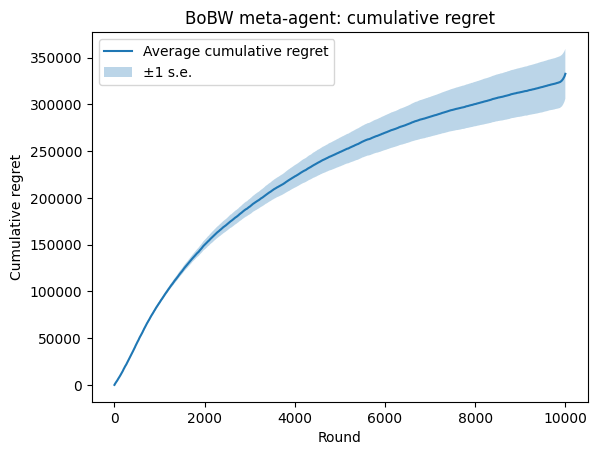

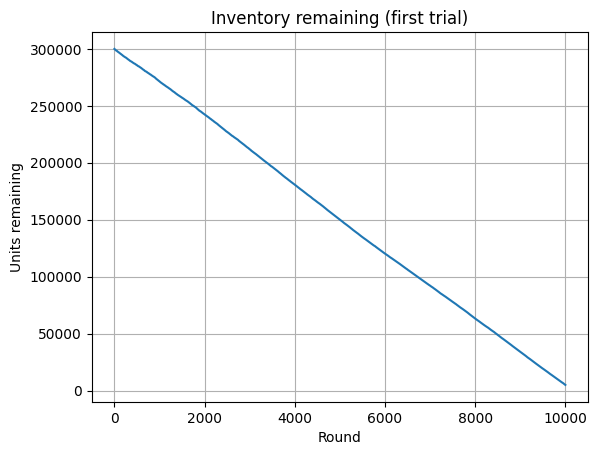

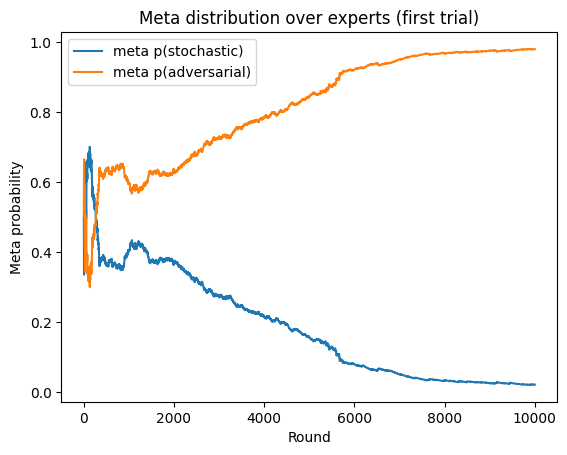

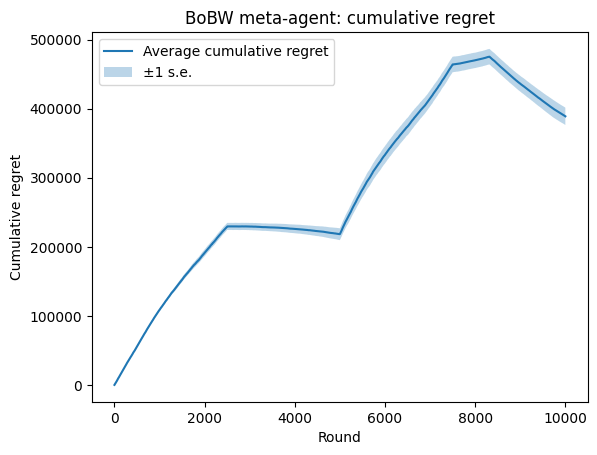

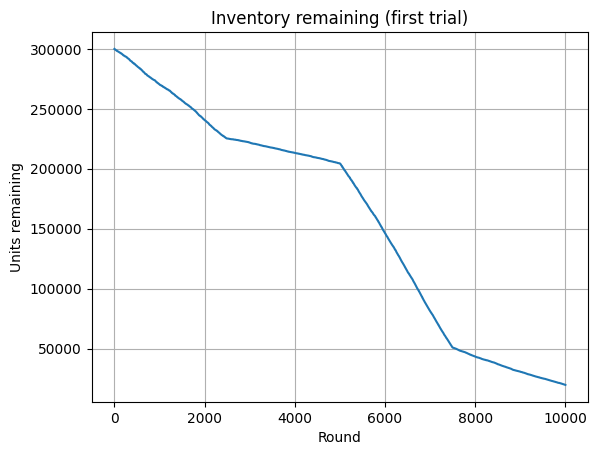

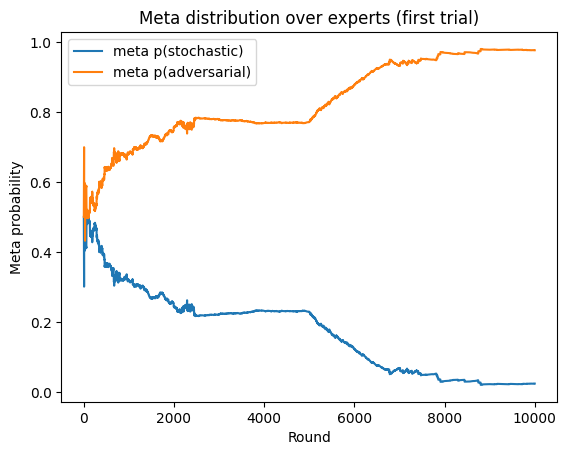

In [ ]:
# Single-run plots
res = run_experiment_bobw(
    env_factory=make_stat_env,      # or make_nonstat_env
    is_nonstationary=False,         # True for NonStationaryValuationEnv
    prices=p_grid, B=B, T=T, cost=cost, n_t=n_t,
    agent_factory=make_agent,       # your factory that returns BoBWMetaPrimalDualAgent
    n_trials=10, log_meta=True, plot=True
)

# Single-run plots
res = run_experiment_bobw(
    env_factory=make_nonstat_env,      # or make_nonstat_env
    is_nonstationary=True,         # True for NonStationaryValuationEnv
    prices=p_grid, B=B, T=T, cost=cost, n_t=n_t,
    agent_factory=make_agent,       # your factory that returns BoBWMetaPrimalDualAgent
    n_trials=10, log_meta=True, plot=True
)

# Scaling (slope α)
T_list, finals, alpha, c = scaling_experiment_bobw(
    env_factory=make_stat_env,      # or make_nonstat_env
    is_nonstationary=False,         # True for NonStationaryValuationEnv
    prices=p_grid, cost=cost, n_t=n_t,
    agent_factory=make_agent,
    T_list=(T, T*2, T*3, T*4),
    n_trials=20, rho=0.3
)
print("Stationary slope α =", alpha, " finals =", finals)

T_list, finals, alpha, c = scaling_experiment_bobw(
    env_factory=make_nonstat_env,
    is_nonstationary=True,
    prices=p_grid, cost=cost, n_t=n_t,
    agent_factory=make_agent,
    T_list=(T, T*2, T*3, T*4),
    n_trials=20, rho=0.3
)
print("Non-stationary slope α =", alpha, " finals =", finals)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ---------- small utils ----------

def safe_invnorm(u):
    """Fast normal quantile (Acklam approx). u in (0,1)."""
    # Coeffs from Peter J. Acklam's approximation
    a = [ -3.969683028665376e+01,  2.209460984245205e+02,
          -2.759285104469687e+02,  1.383577518672690e+02,
          -3.066479806614716e+01,  2.506628277459239e+00 ]
    b = [ -5.447609879822406e+01,  1.615858368580409e+02,
          -1.556989798598866e+02,  6.680131188771972e+01,
          -1.328068155288572e+01 ]
    c = [ -7.784894002430293e-03, -3.223964580411365e-01,
          -2.400758277161838e+00, -2.549732539343734e+00,
           4.374664141464968e+00,  2.938163982698783e+00 ]
    d = [ 7.784695709041462e-03,  3.224671290700398e-01,
          2.445134137142996e+00,  3.754408661907416e+00 ]
    if not (0.0 < u < 1.0):
        return np.nan
    plow  = 0.02425
    phigh = 1 - plow
    if u < plow:
        q = np.sqrt(-2*np.log(u))
        return (((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) / \
               ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
    if phigh < u:
        q = np.sqrt(-2*np.log(1-u))
        return -(((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5]) / \
                 ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
    q = u - 0.5
    r = q*q
    return (((((a[0]*r + a[1])*r + a[2])*r + a[3])*r + a[4])*r + a[5]) * q / \
           (((((b[0]*r + b[1])*r + b[2])*r + b[3])*r + b[4])*r + 1)

def moving_avg(x, k=50):
    k = max(1, int(k))
    if len(x) < k: return np.array(x, dtype=float)
    s = np.convolve(x, np.ones(k), mode='valid')/k
    pad = np.full(k-1, s[0])
    return np.concatenate([pad, s])

# ---------- deep trace runner ----------

def run_one_trial_with_trace(env_factory, is_nonstationary,
                             prices, B, T, cost, n_t,
                             agent_factory, seed=0):
    env = env_factory()
    agent = agent_factory(T=T, B=B, seed=seed)

    p_max = float(np.max(prices))
    # per-round traces
    price_idx, price, p_overall = [], [], []
    d_list, r_list, q_used = [], [], []
    lam_list, g_list = [], []
    meta_p_list = []   # if agent exposes _meta_probs()

    stock = B
    oracle_curve = None
    for t in range(1, T+1):
        # log meta probs if available
        if hasattr(agent, "_meta_probs"):
            try:
                meta_p_list.append(agent._meta_probs().copy())
            except Exception:
                meta_p_list.append(None)

        arm_idx, p_t, prob = agent.select_price()

        # environment step
        if is_nonstationary:
            d_t, r_t, q_t = env.round(t, p_t, n_t=n_t)
            q_used.append(q_t)
        else:
            d_t, r_t = env.round(p_t, n_t)
            # estimate q for logging using provided stationary conversion_probability
            try:
                q_est = conversion_probability(p_t)
            except NameError:
                q_est = np.nan
            q_used.append(q_est)

        # cap by remaining inventory
        if d_t > stock:
            d_t = stock
            r_t = (p_t - cost) * d_t
        stock -= d_t

        # agent update
        agent.observe_and_update(arm_idx, prob, d_t)

        # compute per-round Lagrangian gain g_t using agent's λ if available
        lam = getattr(agent, "lam", np.nan)
        g_t = (p_t - cost - (lam if np.isfinite(lam) else 0.0)) * d_t

        # log
        price_idx.append(arm_idx); price.append(p_t); p_overall.append(prob)
        d_list.append(d_t); r_list.append(r_t); lam_list.append(lam); g_list.append(g_t)

    # oracle curve for this env + horizon + budget
    if is_nonstationary:
        oc, best_idx = oracle_curve_nonstationary(env, prices, T, B, n_t, cost)
    else:
        oc, best_idx = oracle_curve_stationary(env, prices, T, B, n_t, cost)
    oracle_curve = oc
    out = {
        "price_idx": np.array(price_idx),
        "price": np.array(price),
        "p_overall": np.array(p_overall),
        "d": np.array(d_list),
        "r": np.array(r_list),
        "q_used": np.array(q_used),
        "lambda": np.array(lam_list),
        "g": np.array(g_list),
        "oracle_curve": oracle_curve,
        "best_idx": int(best_idx),
        "meta_probs": np.array(meta_p_list) if len(meta_p_list)>0 and meta_p_list[0] is not None else None,
        "target_sales": B / T
    }
    return out

# ---------- plotting helpers ----------

def plot_trace(trace, title_prefix=""):
    T = trace["r"].size
    t = np.arange(1, T+1)

    # cumulative regret
    cum_regret = np.cumsum(trace["oracle_curve"] - trace["r"])
    plt.figure(); plt.plot(t, cum_regret)
    plt.xlabel("Round"); plt.ylabel("Cumulative regret")
    plt.title(f"{title_prefix} Cumulative regret"); plt.grid(True); plt.show()

    # price index over time
    plt.figure(); plt.plot(t, trace["price_idx"], lw=0.7)
    plt.axhline(trace["best_idx"], ls='--', label='Oracle best fixed index')
    plt.xlabel("Round"); plt.ylabel("Price index"); plt.legend(); plt.title(f"{title_prefix} Chosen price index"); plt.show()

    # demand vs target (moving averages)
    tgt = trace["target_sales"]
    plt.figure()
    plt.plot(t, moving_avg(trace["d"], 50), label="MA(d_t)")
    plt.axhline(tgt, color='k', ls='--', label="Target B/T")
    plt.xlabel("Round"); plt.ylabel("Units/round"); plt.legend()
    plt.title(f"{title_prefix} Demand vs target (50-step MA)"); plt.grid(True); plt.show()

    # lambda trace if available
    lam = trace["lambda"]
    if np.isfinite(lam).any():
        plt.figure(); plt.plot(t, lam)
        plt.xlabel("Round"); plt.ylabel("λ (shadow price)")
        plt.title(f"{title_prefix} Lambda (inventory dual)"); plt.grid(True); plt.show()

    # meta probabilities if available
    if trace["meta_probs"] is not None:
        mp = trace["meta_probs"]
        if mp.ndim == 2 and mp.shape[1] == 2:
            plt.figure()
            plt.plot(t, mp[:,0], label="p(stochastic)")
            plt.plot(t, mp[:,1], label="p(adversarial)")
            plt.xlabel("Round"); plt.ylabel("Meta prob"); plt.legend()
            plt.title(f"{title_prefix} Meta weights over experts"); plt.show()

    # per-round prob of chosen arm (overall)
    plt.figure(); plt.plot(t, trace["p_overall"], lw=0.8)
    plt.xlabel("Round"); plt.ylabel("P(chosen arm)")
    plt.title(f"{title_prefix} Overall prob of chosen arm"); plt.grid(True); plt.show()


In [21]:
def scaling_experiment_debug(env_factory, is_nonstationary,
                             prices, cost, n_t, agent_factory,
                             T_list=(250,500,1000,2000), n_trials=20, rho=0.3):
    finals = []
    finals_per_T = []
    for T in T_list:
        B_T = int(rho * n_t * T)
        trial_R = []
        for seed in range(n_trials):
            env = env_factory()
            agent = agent_factory(T=T, B=B_T, seed=seed)
            stock = B_T
            agent_rewards = np.zeros(T)
            for t in range(1, T+1):
                arm_idx, p_t, prob = agent.select_price()
                try:
                    d_t, r_t, _ = env.round(t, p_t, n_t=n_t)  # non-stationary
                except TypeError:
                    d_t, r_t = env.round(p_t, n_t)            # stationary
                if d_t > stock:
                    d_t = stock; r_t = (p_t - cost) * d_t
                stock -= d_t
                agent.observe_and_update(arm_idx, prob, d_t)
                agent_rewards[t-1] = r_t
            if is_nonstationary:
                oracle_curve, _ = oracle_curve_nonstationary(env, prices, T, B_T, n_t, cost)
            else:
                oracle_curve, _ = oracle_curve_stationary(env, prices, T, B_T, n_t, cost)
            R_T = float(np.sum(oracle_curve) - np.sum(agent_rewards))
            trial_R.append(R_T)
        finals.append(float(np.mean(trial_R)))
        finals_per_T.append(trial_R)
    x = np.log(np.array(T_list, dtype=float))
    y = np.log(np.array(finals, dtype=float))
    alpha, logc = np.polyfit(x, y, 1)
    return {
        "T_list": T_list,
        "finals_mean": finals,
        "finals_all": finals_per_T,
        "alpha": float(alpha),
        "c": float(np.exp(logc)),
        "finals_over_T": [f/t for f,t in zip(finals, T_list)]
    }

def plot_ratio_curves(avg_cum_regret, mode='adv'):
    t = np.arange(1, avg_cum_regret.size+1)
    denom = np.sqrt(t) if mode=='adv' else np.log(np.maximum(2, t))
    plt.figure(); plt.plot(t, avg_cum_regret/denom)
    plt.xlabel('t'); plt.ylabel('Regret / denom')
    plt.title(f'Ratio curve vs {"sqrt(t)" if mode=="adv" else "log t"}'); plt.grid(True); plt.show()


In [22]:
def stationary_optimal_price_estimate(mu, sigma, rho):
    """Critical fractile p* ≈ mu + sigma * Φ^{-1}(1 - rho)."""
    return mu + sigma * safe_invnorm(1 - rho)

def grid_diagnostics(prices, cost, n_t, T, B, stationary_params=None):
    rho = B / (n_t * T)
    out = {"rho": rho}
    if stationary_params is not None:
        mu, sigma = stationary_params
        p_star = stationary_optimal_price_estimate(mu, sigma, rho)
        idx = int(np.argmin(np.abs(prices - p_star)))
        out.update({
            "p_star_est": float(p_star),
            "nearest_grid_price": float(prices[idx]),
            "grid_gap": float(abs(prices[idx] - p_star))
        })
    out["grid_step_max"] = float(np.max(np.diff(prices)))
    out["grid_step_min"] = float(np.min(np.diff(prices)))
    return out

def inventory_tracking_stats(trace):
    tgt = trace["target_sales"]
    d = trace["d"]
    err = d - tgt
    return {
        "mae_d_minus_target": float(np.mean(np.abs(err))),
        "mean_d": float(np.mean(d)),
        "target": float(tgt)
    }


In [23]:
def slope_without_inventory(env_factory, is_nonstationary,
                            prices, cost, n_t, agent_factory,
                            T_list=(T,T*2,T*3,T*4), n_trials=10):
    """Set a gigantic budget so the dual barely matters."""
    finals = []
    for T in T_list:
        B_T = 10**9    # effectively unconstrained
        trial_R = []
        for seed in range(n_trials):
            env = env_factory()
            agent = agent_factory(T=T, B=B_T, seed=seed)
            agent_rewards = np.zeros(T)
            for t in range(1, T+1):
                arm_idx, p_t, prob = agent.select_price()
                try:
                    d_t, r_t, _ = env.round(t, p_t, n_t=n_t)
                except TypeError:
                    d_t, r_t = env.round(p_t, n_t)
                agent.observe_and_update(arm_idx, prob, d_t)
                agent_rewards[t-1] = r_t
            if is_nonstationary:
                oracle_curve, _ = oracle_curve_nonstationary(env, prices, T, B_T, n_t, cost)
            else:
                oracle_curve, _ = oracle_curve_stationary(env, prices, T, B_T, n_t, cost)
            trial_R.append(float(np.sum(oracle_curve) - np.sum(agent_rewards)))
        finals.append(float(np.mean(trial_R)))
    x = np.log(np.array(T_list, dtype=float)); y = np.log(np.array(finals, dtype=float))
    alpha, logc = np.polyfit(x, y, 1)
    return float(alpha), [f/t for f,t in zip(finals, T_list)]


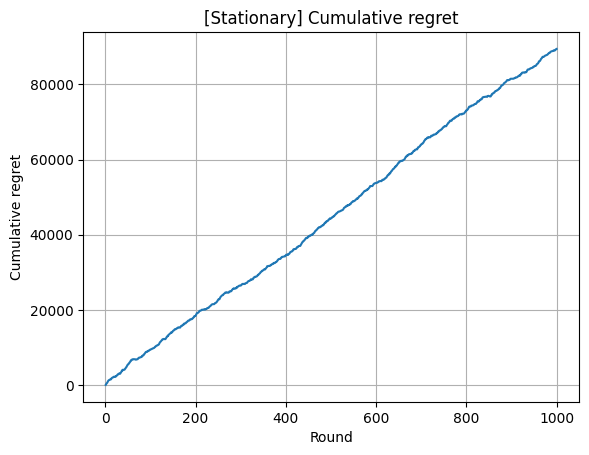

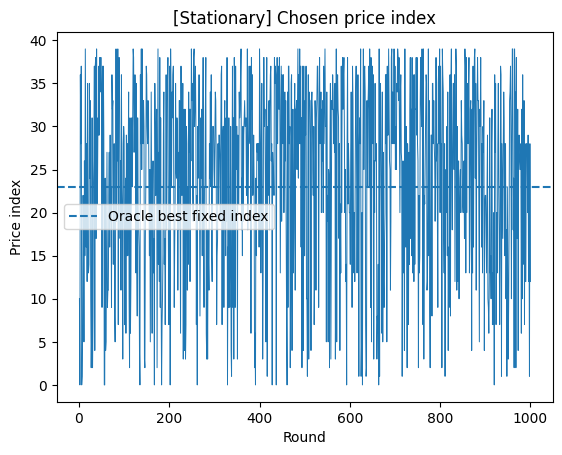

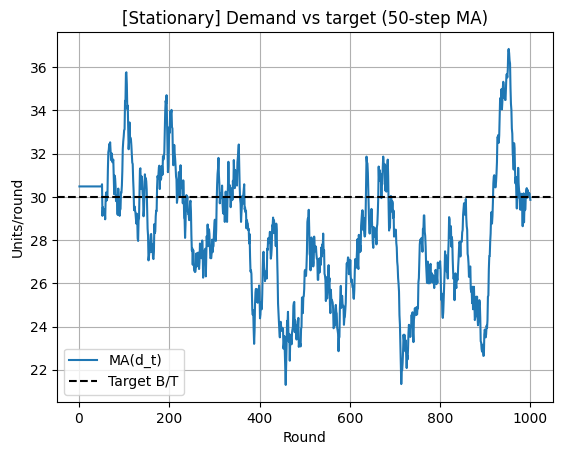

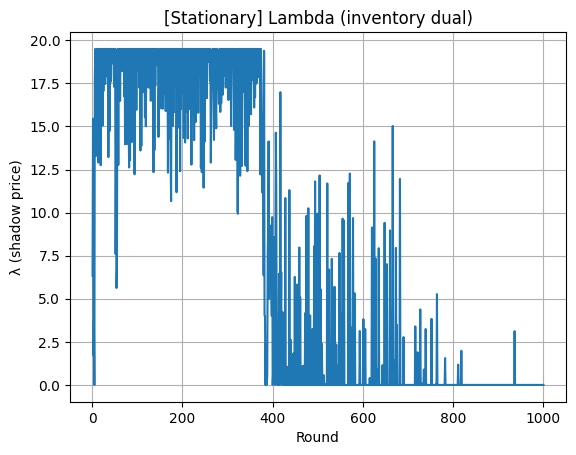

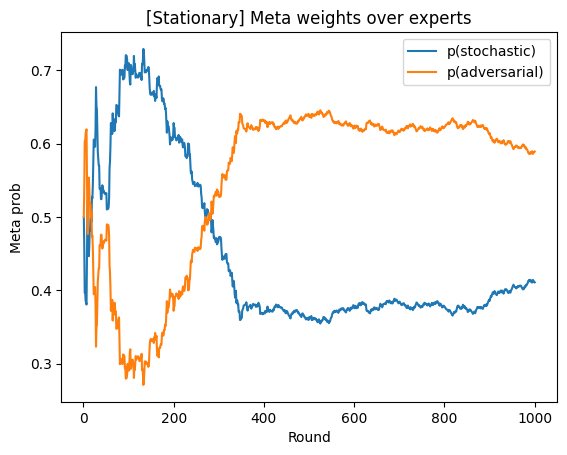

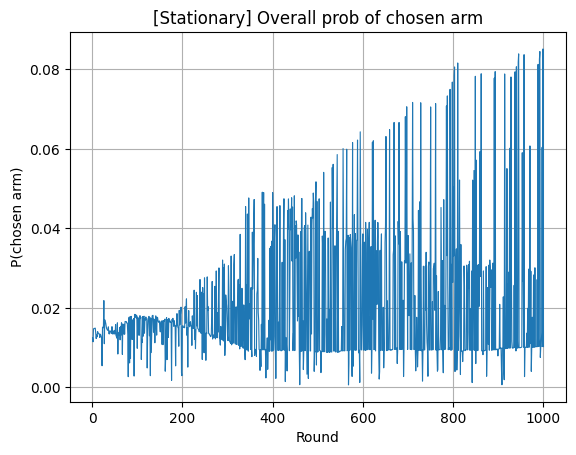

Inventory tracking: {'mae_d_minus_target': 18.152, 'mean_d': 28.428, 'target': 30.0}
Grid diag (if you know mu0, sigma0): {'rho': 0.3, 'p_star_est': 11.048801026558591, 'nearest_grid_price': 11.08, 'grid_gap': 0.031198973441409095, 'grid_step_max': 0.38000000000000256, 'grid_step_min': 0.36999999999999744}


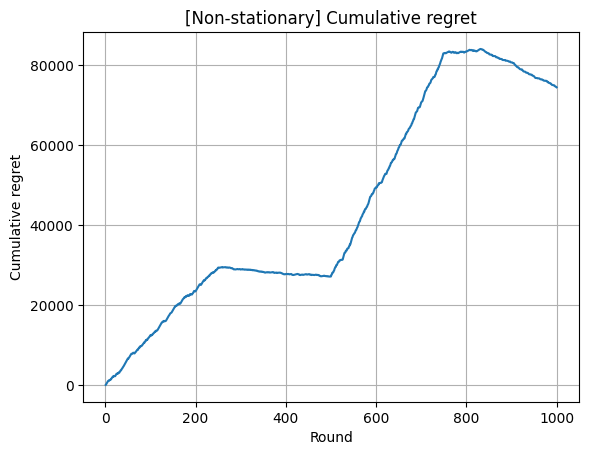

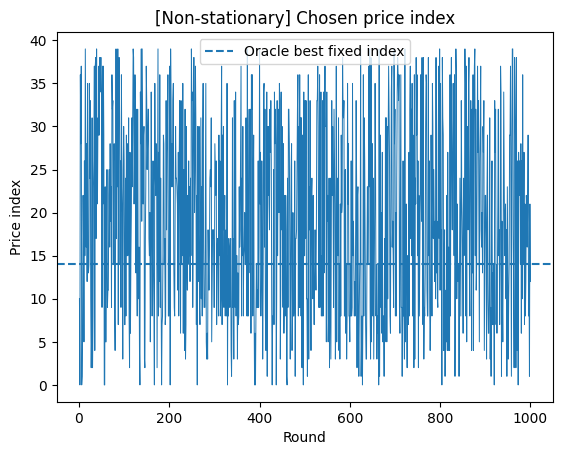

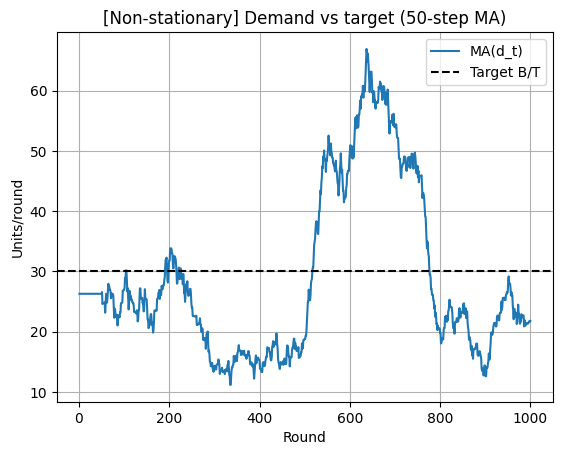

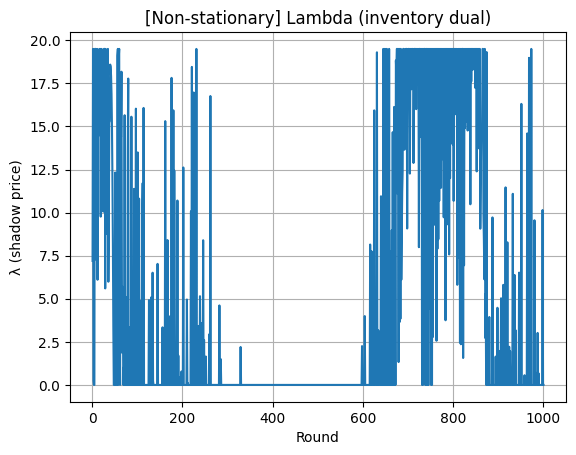

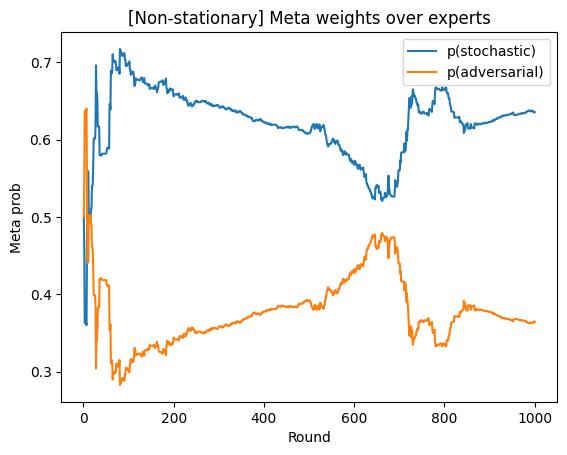

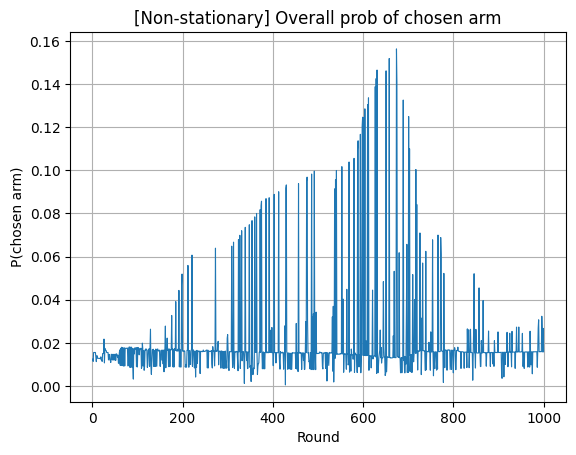

Inventory tracking (nonstat): {'mae_d_minus_target': 31.686, 'mean_d': 28.908, 'target': 30.0}
Stationary slope alpha = 0.6625067504703736  finals = [88835.23200000012, 149570.25750000024, 188052.90150000007, 222390.6365000005]  finals/T = [88.83523200000012, 74.78512875000013, 62.68430050000002, 55.59765912500012]


KeyboardInterrupt: 

In [24]:
# Example config (adjust to your setup)
mu0, sigma0 = 10.0, 2.0  # <-- define these


# 1) Deep trace (stationary)
trace_stat = run_one_trial_with_trace(
    env_factory=make_stat_env,
    is_nonstationary=False,
    prices=p_grid, B=B, T=T, cost=cost, n_t=n_t,
    agent_factory=make_agent,
    seed=0
)
plot_trace(trace_stat, title_prefix="[Stationary]")

print("Inventory tracking:", inventory_tracking_stats(trace_stat))
print("Grid diag (if you know mu0, sigma0):",
      grid_diagnostics(p_grid, cost, n_t, T, B, stationary_params=(mu0, sigma0)))

# 2) Deep trace (non-stationary)
trace_ns = run_one_trial_with_trace(
    env_factory=make_nonstat_env,
    is_nonstationary=True,
    prices=p_grid, B=B, T=T, cost=cost, n_t=n_t,
    agent_factory=make_agent,
    seed=0
)
plot_trace(trace_ns, title_prefix="[Non-stationary]")
print("Inventory tracking (nonstat):", inventory_tracking_stats(trace_ns))

# 3) Scaling + slopes
res_stat = scaling_experiment_debug(
    env_factory=make_stat_env, is_nonstationary=False,
    prices=p_grid, cost=cost, n_t=n_t, agent_factory=make_agent,
    T_list=(T,T*2,T*3,T*4), n_trials=20, rho=0.3
)
print("Stationary slope alpha =", res_stat["alpha"], " finals =", res_stat["finals_mean"],
      " finals/T =", res_stat["finals_over_T"])

res_ns = scaling_experiment_debug(
    env_factory=make_nonstat_env, is_nonstationary=True,
    prices=p_grid, cost=cost, n_t=n_t, agent_factory=make_agent,
    T_list=(T,T*2,T*3,T*4), n_trials=20, rho=0.3
)
print("Non-stationary slope alpha =", res_ns["alpha"], " finals =", res_ns["finals_mean"],
      " finals/T =", res_ns["finals_over_T"])

# 4) Isolate inventory controller effect
alpha_noinv_stat, finals_over_T_stat = slope_without_inventory(
    env_factory=make_stat_env, is_nonstationary=False,
    prices=p_grid, cost=cost, n_t=n_t, agent_factory=make_agent,
    T_list=(T,T*2,T*3,T*4), n_trials=10
)
print("alpha (no inventory, stationary) =", alpha_noinv_stat, " finals/T =", finals_over_T_stat)

alpha_noinv_ns, finals_over_T_ns = slope_without_inventory(
    env_factory=make_nonstat_env, is_nonstationary=True,
    prices=p_grid, cost=cost, n_t=n_t, agent_factory=make_agent,
    T_list=(T,T*2,T*3,T*4), n_trials=10
)
print("alpha (no inventory, non-stationary) =", alpha_noinv_ns, " finals/T =", finals_over_T_ns)
